# Movie Recommender System
###  Watching a movie is the most peaceful thing for me (even watching a movie like below). I love movies, once upon a time I wanted to become a movie Director or Screenplay writer, but I couldn't (at least for now). Even I couldn't become a Director these flames in my heart haven't gone out. I wanted to somehow useful, what can I do? Then the idea came up to my mind. You know, when your friends talking about a movie and they ask any other movie recommendation which, similar to that movie. As a intellectual being you thinking about its plot and then compare its plot similar movies which you watched. Eventually you came up with a recommendation. I want from Machine to make this type of recommendation to people instead of you. 

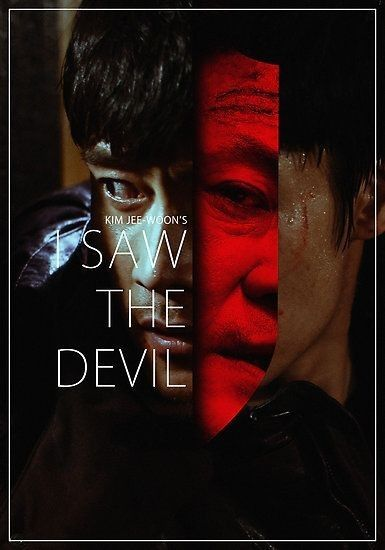

**You should definetely watch this movie above!**

In [1]:
!pip install -q sentence_transformers
!pip install -q faiss-gpu
!pip install -q yake

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import transformers
import faiss #For calculating similarity between embeddings. 
from sentence_transformers import SentenceTransformer #For Sentence Embeddings.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### The beginning idea's itself was very simple. If the two movies' plots similar to each other, then the movies are the similar.

We take text samples as an input(in this case, it's the plots of the movies) and extract N number of keywords from each of them.(I used 25 in this notebook, because of the kaggle's limitations. I observed, the more is the better). This N keywords represents our whole plot. Then we convert these keywords into sentence embeddings using *Sentence Tokenizer*(There are bunch of methods which can turn words into embeddings, but I observed Sentence Tokenizer worked great). 


For the sake of simplicity, let's say we had 50 different plots from different movies and we extracted keyword, then convert them into embeddings. Remember, if the plots are similar, then the movies are similar. I used 'faiss' library to calculate the similarities between embeddings. I took 4 most similar plots as an output in this notebook.

In [3]:
plots = pd.read_csv('/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv')

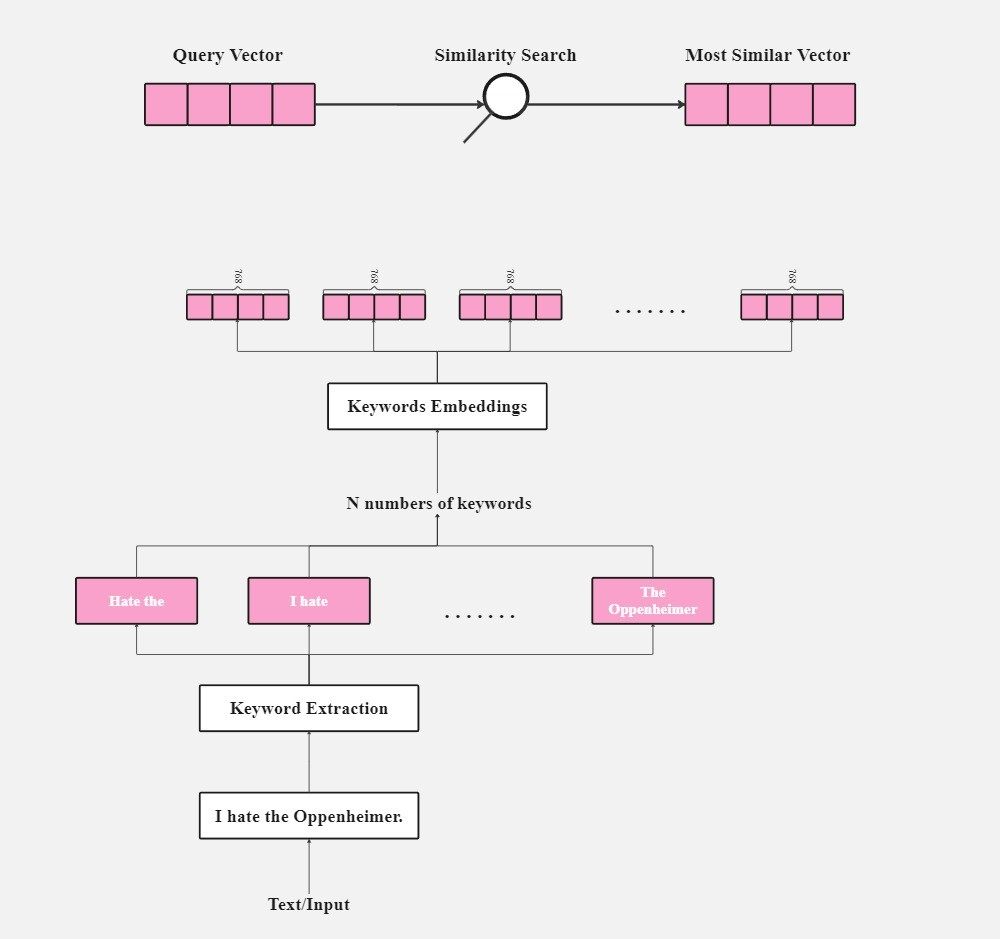
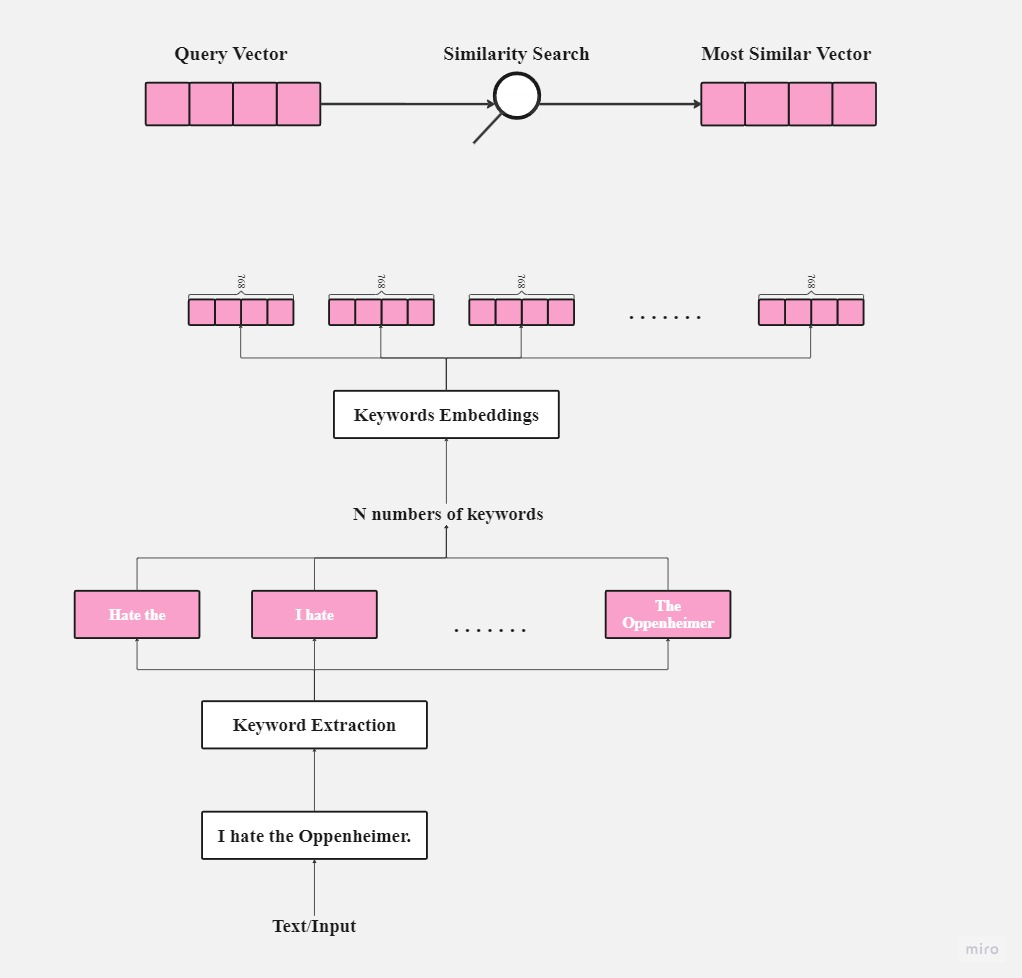

## For this demo I was need a dataset, which contain both movie plots and movie titles. I found this dataset, which contains decent amount of unique movies(and also their plot).

In [4]:
plots.info() #We just need Plot and Title columns. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [5]:
plots.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [6]:
plots['Genre'].sample(5) #I'm seeing the 'mess' in the 'Genre' column.

17092    science fiction action-comedy
30963                 action thriller 
6489                             crime
27127                     action/drama
28023                          unknown
Name: Genre, dtype: object

In [7]:
len(plots['Genre'].unique()) #As I expected there is huge variety of unique values in genres.

2265

In [8]:
def get_len(row: str):
    length_all = 0 
    number_of_samples = len(plots)
    for delta in plots[row]:
        length_all += len(delta) #We add length of the each plot to 'length_all'.
    
    return round((length_all / number_of_samples))

#This function above will help us to demonstrate average length of the plots

In [9]:
lengths = get_len('Plot') #Average length of the plots.

In [10]:
sen_transformer = SentenceTransformer('all-mpnet-base-v2') #Sentence Transformer

In [11]:
import yake #Library for keyword extraction

This function below takes movie plots as an input and returns a list which contains all keywords for each movie.

In [15]:
movies = plots.sample(25000, random_state = 42) #Randomly selecting 25000 samples from dataset.
movies.reset_index(drop = True, inplace = True)
def get_keywords():
    kw_extraction = yake.KeywordExtractor(lan = 'en', n = 3, top = 25)
    """
    lan - represents the language that you want to extract keyword.
    
    n - represents maximum n-gram length.
    
    top - number of keywords that will be extracted.
    
    """
    from tqdm import tqdm
    sentences = []
    total_iteration = len(movies.sample(25000))
    with tqdm(total= total_iteration) as pbar:
        for delta in movies['Plot']:
            texts = []
            keywords = kw_extraction.extract_keywords(delta)
            for keyword, _ in keywords:
                texts.append(keyword.lower())

            joined_text = ','.join(texts)
            sentences.append(joined_text)

            pbar.update(1)
    
    return sentences

In [ ]:
#With whole text
#def get_embbedings(dataframe = plots):
    #num_of_sentence = []
    #sentences = []
    #embeddings_for_each_plot = []
    #final_embeddings = []
    #for delta in dataframe['Plot']:
        #text = delta.split('.')
        #num_of_sentence.append(len(text))
        #sentences.extend(text)

    #embeddings = sen_transformer.encode(sentences)

    #for delta in num_of_sentence:
        #if delta == num_of_sentence[0]:
           # embeddings_for_each_plot.append(embeddings[:delta])
           # prev_delta = delta
        #else:
         #   embeddings_for_each_plot.append(embeddings[prev_delta:(delta+prev_delta)])
          #  prev_delta = delta
    
   # for delta in embeddings_for_each_plot:
    #    embedding_sums = np.array(np.sum(delta, axis = 0))
     #   final_embeddings.append(embedding_sums)
    
    #return final_embeddings

In [16]:
keywordsALL = get_keywords() #Get all the keywords.

  0%|          | 21/25000 [00:03<1:06:59,  6.21it/s]


KeyboardInterrupt: 

In [ ]:
#with open('/kaggle/working/keyword2.txt', 'w') as file:
    #for line in keywordsALL:
        #file.write(line + '\n')
        

In [ ]:
#path = '/kaggle/input/movie-keywords-demo/keyword2.txt' 

#with open(path, 'r') as f:
    #keywords = f.read()
    #keywordsALL = keywords.splitlines()

In [ ]:
embeddings = sen_transformer.encode(keywordsALL) #Get the embeddings from keywords.

In [ ]:
#This function takes plot_index, embeddings, number of similar plots that you want to see and returns the index of similar movies in the dataset.

def get_similarity(plot_index, embeddings, num_of_similars):
    
    similarity = faiss.IndexFlatL2(768) #It uses L2 norm for calculating similarity 
    similarity.add(embeddings) 
    query_vector = embeddings[plot_index]
    
    #We will calculate similarity scores from all plots against query_vector.
    
    query_vector = query_vector.reshape(1, 768) #Adding 1 extra dimension to query vector.
    
    D, I = similarity.search(query_vector, num_of_similars) #This gives as most similar embeddings indexes with our query vector.
    
    return I

In [ ]:
"""
This function is similar the function above, but this time it takes a plot our a message from user and print movies that similar the movie that
the user describe

"""

def get_similarity_from_plot(user_input, embeddings, num_of_similars, print_plot):
    
    kw_extractor = yake.KeywordExtractor(lan = 'en', n = 3, top = 25)
    similarity = faiss.IndexFlatL2(768)
    similarity.add(embeddings)
    text = []
    movies_reset_index = movies.reset_index(drop = True)
    keywords = kw_extractor.extract_keywords(user_input)
    
    
    
    for kw, _ in keywords:
        text.append(kw)
    
    joined_keywords = ','.join(text)
    input_embedding = sen_transformer.encode(joined_keywords)
    query_vector = input_embedding.reshape(-1, 768)
    
    #We are extracting keywords from user input and then convert them into embeddings.
    
    D, I = similarity.search(query_vector, num_of_similars)
    movie_titles = movies_reset_index.loc[I.reshape(-1), 'Title'].tolist()
    movie_plots = movies_reset_index.loc[I.reshape(-1), 'Plot'].tolist()
    rand_index = np.random.randint(num_of_similars, size = 1)
    
    print(f'I recommend, {movie_titles}')
    
    if print_plot == True:
        print(f'Here is the plot:\n{movie_plots[rand_index[0]]}')

In [ ]:
indexes = get_similarity(plot_index = 1255, embeddings = embeddings, num_of_similars = 5 )
print(indexes.reshape(-1))

In [ ]:
text = """
Luke Skywalker stays with his aunt and uncle on a farm on Tatooine. 
He is desperate to get off this planet and get to the Academy like his friends, 
but his uncle needs him for the next harvest. Meanwhile, an evil emperor has taken over the galaxy, 
and has constructed a formidable "Death Star" capable of destroying whole planets. 
Princess Leia, a leader in the resistance movement, acquires plans of the Death Star, 
places them in R2-D2, a droid, and sends him off to find Obi-wan Kenobi. Before he finds him, 
R2-D2 ends up on the Skywalkers' farm with his friend C-3PO. R2-D2 then wanders into the desert, 
and when Luke follows, they eventually come across Obi-wan. Will Luke, Obi-wan, and the two droids 
be able to destroy the Death Star, or will the Emperor rule forever?
"""

It is time to try our 'dummy model'. I copied the plot for Star Wars: Episode IV - A New Hope, let's see if the model can recommend us the similar movies based on its plot.

In [ ]:
get_similarity_from_plot(user_input = text, embeddings = embeddings, num_of_similars = 4, print_plot = False)

#If print_plot set True you can print the plots for movies that our model recommend.

Wow, It knows the plot is about 'wars' in the stars and hey look, it recommend another movie except Star Wars franchise! Let's try again with different plot!

In [ ]:
text2 = """ In sun-kissed Los Angeles, a pair of morning commuters jammed on a wide stretch of highway are off to a rocky start. But suave Sebastian, a charming jazz pianist whom life's got him on the ropes, and lovely Mia, a brilliant playwright waiting for her big break, are meant for each other. On the one hand, Sebastian thinks he has a serious plan for the future. On the other hand, Mia squanders herself in meaningless auditions, mesmerised by old Hollywood glamour. However, as the incurable romantics keep running into each other under the city's starry nights and plum-hued sunrises, a magical, old-school tap-dance romance timidly begins. Such is the power of effervescent love: it inspires people to have long walks while gazing at the colourful Milky Way of the city's flickering lights. But life is as exciting as it is challenging. After all, no one knows what tomorrow holds. And as the young idealists veer from their dreams, questions arise. Does true love exist only in movies? Do dreams come true in real life?
"""

In [ ]:
 get_similarity_from_plot(user_input = text2, embeddings = embeddings, num_of_similars = 3, print_plot = False)

**As you can see, our model worked pretty well. Of course it is not the best Recommender model, but at least it's working! Feel free to copy this notebook and try to improve the model. For the next step, I want to merge this model with an LM(Language Model) and improve it.**

*Note: Keep in mind that our dataset is very small. Because of that, our model may not perform very well in all types of 'plot'.*

# THE END!
### If you like this notebook please give an upvote. May the force be with you! 

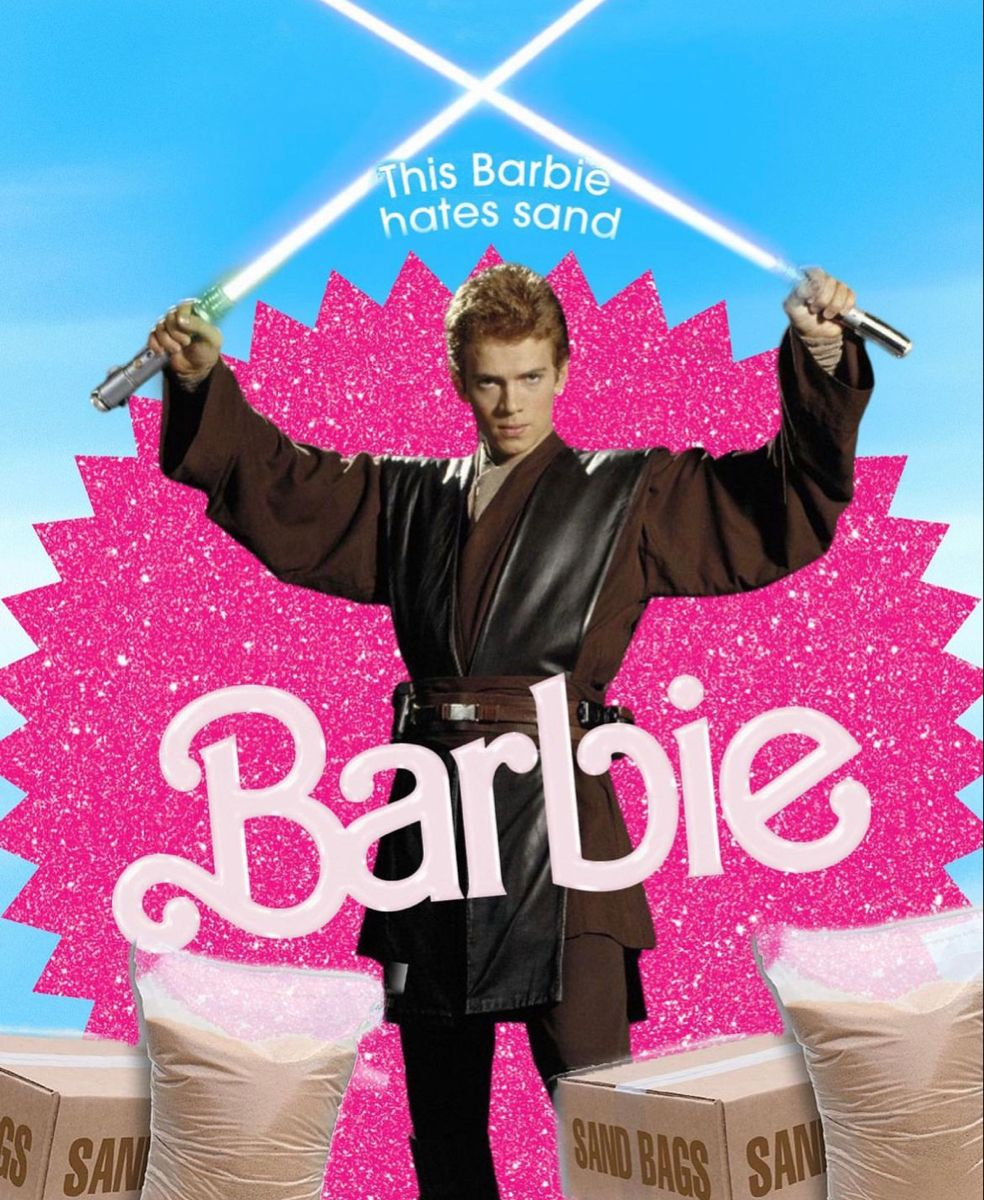